In [1]:
!pip install catboost librosa resampy soundfile tqdm kagglehub optuna optuna-dashboard


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)
!cp -rf {path} ./dataset

Path to dataset files: /Users/dima/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [1]:
import pandas as pd
import numpy as np
from model import *
from dagxtractor import DAGXtractor, mapper, flat_mapper

In [2]:
import pandas as pd
df = pd.read_csv("dataset/Data/features_30_sec.csv")
df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [3]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(columns=['label'])  # Features: e.g., 'track' and 'statistics'
y = df['label']  # Target: 'label'

# Split the dataset while preserving class proportions
X_train, X_eval, y_train, y_eval = train_test_split(
    X, y,
    test_size=0.2,  # 20% for testing
    stratify=y,     # Preserve class proportions
    random_state=42 # For reproducibility
)

In [4]:
# Drop corrupted sample
idx = X_train.index[X_train["filename"] == "jazz.00054.wav"]
X_train = X_train.drop(index=idx)
y_train = y_train.drop(index=idx)

In [7]:
model, acc = train_and_evaluate_catboost(
    X_train.drop(columns=["filename", "length"]).to_numpy(),
    y_train.to_numpy(),
)

0:	learn: 0.2989045	total: 61.7ms	remaining: 30.8s
100:	learn: 0.8247261	total: 296ms	remaining: 1.17s
200:	learn: 0.9092332	total: 791ms	remaining: 1.18s
300:	learn: 0.9561815	total: 1.15s	remaining: 761ms
400:	learn: 0.9812207	total: 1.42s	remaining: 350ms
499:	learn: 0.9953052	total: 1.66s	remaining: 0us
0:	learn: 0.3818466	total: 4.2ms	remaining: 2.09s
100:	learn: 0.8356808	total: 239ms	remaining: 945ms
200:	learn: 0.9107981	total: 483ms	remaining: 719ms
300:	learn: 0.9655712	total: 722ms	remaining: 478ms
400:	learn: 0.9859155	total: 951ms	remaining: 235ms
499:	learn: 0.9921753	total: 1.18s	remaining: 0us
0:	learn: 0.3302034	total: 3.95ms	remaining: 1.97s
100:	learn: 0.8325509	total: 243ms	remaining: 960ms
200:	learn: 0.9139280	total: 476ms	remaining: 708ms
300:	learn: 0.9546166	total: 704ms	remaining: 465ms
400:	learn: 0.9796557	total: 936ms	remaining: 231ms
499:	learn: 0.9890454	total: 1.16s	remaining: 0us
0:	learn: 0.3208138	total: 4.25ms	remaining: 2.12s
100:	learn: 0.8435055	t

In [5]:
import soundfile as sf
import librosa
import numpy as np
import resampy

In [6]:
sr = 22050
hop_length = 512
n_mfcc = 20
n_mels = 128
n_bins = 84
bins_per_octave = 12
fmin = librosa.note_to_hz("C1")
fmax = fmin * 2 ** 7
n_fft=2048
mel_proj = librosa.filters.mel(sr=sr, n_fft=n_fft, fmin=fmin, fmax=fmax)

class Extractor(DAGXtractor):
    @mapper("audio")
    def load_audio(x) -> [np.ndarray]:
        file_path = f"dataset/Data/genres_original/{x[0].split('.')[0]}/{x[0]}"
        y, sr = sf.read(file_path)
        if len(y.shape) == 2:  # Convert stereo to mono
            y = np.mean(y, dim=0)
        if sr != 22050:
            y = resample(y, sr, 22050)
        return y[:660000].astype('float32') # Sizes of samples slightly differ
    @mapper("stats")
    def stats(x):
        return x[2:-1]
    @mapper("labels")
    def labels(x):
        return x[-1]
    @mapper("rms", batched=True)
    def rms(audio):
        return np.sqrt(np.mean(audio**2, axis=-1))
    @mapper("complex_stft", batched=False, uniform=True)
    def complex_stft(audio):
        return librosa.stft(audio, hop_length=hop_length, n_fft=n_fft)
    @mapper("stft", batched=True)
    def stft(complex_stft):
        return np.abs(complex_stft)
    @mapper("complex_cqt", batched=False, uniform=True)
    def complex_cqt(audio):
        return librosa.cqt(audio, sr=sr, hop_length=hop_length, fmin=fmin, bins_per_octave=bins_per_octave, n_bins=n_bins)
    @mapper("cqt", batched=True)
    def cqt(complex_cqt):
        return np.abs(complex_cqt)
    @mapper("mel", batched=False)
    def mel(stft):
        return librosa.power_to_db(np.einsum("ij,jk->ik", mel_proj, stft**2, optimize=True))
    @mapper("mfcc", batched=True)
    def mfcc(audio):
        return librosa.feature.mfcc(y=audio, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc)

In [7]:
E_train = Extractor(
    x=np.hstack([X_train.to_numpy(), y_train.to_numpy().reshape(-1, 1)]),
)
E_eval = Extractor(
    x=np.hstack([X_eval.to_numpy(), y_eval.to_numpy().reshape(-1, 1)])
)
E_train.full_extract()

Running extractor for features audio at 2025-02-12 10:09:57.559865
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:10:00.213436 total running time 0:00:02.653571
Running extractor for features complex_stft at 2025-02-12 10:10:00.213477
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:10:10.358905 total running time 0:00:10.145428
Running extractor for features labels at 2025-02-12 10:10:10.359792
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:10:10.377621 total running time 0:00:00.017829
Running extractor for features stats at 2025-02-12 10:10:10.377840
Failed compiling function, will use plain python wrapper.


  0%|          | 0/100 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:10:10.395405 total running time 0:00:00.017565
Running extractor for features complex_cqt at 2025-02-12 10:10:10.395440
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:10:26.719088 total running time 0:00:16.323648
Running extractor for features cqt at 2025-02-12 10:10:26.719156


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:10:27.199868 total running time 0:00:00.480712
Running extractor for features stft at 2025-02-12 10:10:27.199901


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:10:59.420277 total running time 0:00:32.220376
Running extractor for features mel at 2025-02-12 10:10:59.421953
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:11:12.600764 total running time 0:00:13.178811
Running extractor for features mfcc at 2025-02-12 10:11:12.600868


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:11:37.210918 total running time 0:00:24.610050
Running extractor for features rms at 2025-02-12 10:11:37.211031


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:11:37.661483 total running time 0:00:00.450452


In [8]:
def bpm_beat(audio):
    return librosa.beat.beat_track(y=audio, sr=sr, hop_length=hop_length)
Extractor.register_mapper(['bpm', 'beat'], bpm_beat, uniform=False)
# Extractor.register_mapper('bpm', lambda audio: librosa.beat.beat_track(y=audio, sr=sr, hop_length=hop_length)[0])

In [9]:
E_train.soft_extract()

Running extractor for features bpm, beat at 2025-02-12 10:11:37.708218


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:12:15.437455 total running time 0:00:37.729237


In [10]:
def stft_hpss(complex_stft):
    stft_harmonic, stft_percussive = librosa.decompose.hpss(complex_stft)
    return np.abs(stft_harmonic), np.abs(stft_percussive)
Extractor.register_mapper(['stft_harmonic', 'stft_percussive'], stft_hpss)

In [11]:
E_train.soft_extract()

Running extractor for features stft_harmonic, stft_percussive at 2025-02-12 10:12:15.476940
Failed compiling function, will use plain python wrapper, exception: can only concatenate list (not "tuple") to list


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:26:33.442735 total running time 0:14:17.965795


In [12]:
# We do it in a single run, for optimization purposes
def mel_hpss(stft_harmonic, stft_percussive):
    return (
        np.mean(stft_harmonic),
        np.var(stft_harmonic),
        np.mean(stft_percussive),
        np.var(stft_percussive),
        librosa.power_to_db(np.einsum("ij,jk->ik", mel_proj, stft_harmonic**2, optimize=True)),
        librosa.power_to_db(np.einsum("ij,jk->ik", mel_proj, stft_percussive**2, optimize=True)),
    )

Extractor.register_mapper(['stft_harmonic_mean', 'stft_harmonic_var', 'stft_percussive_mean', 'stft_percussive_var', 'mel_harmonic', 'mel_percussive'], mel_hpss)
E_train.soft_extract()

Running extractor for features stft_harmonic_mean, stft_harmonic_var, stft_percussive_mean, stft_percussive_var, mel_harmonic, mel_percussive at 2025-02-12 10:26:33.496627
Failed compiling function, will use plain python wrapper, exception: tuple index out of range


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:27:40.312161 total running time 0:01:06.815534


In [13]:
Extractor.register_mapper(['cqt_harmonic', 'cqt_percussive'], lambda cqt: librosa.decompose.hpss(cqt))


In [14]:
E_train.soft_extract()

Running extractor for features cqt_harmonic, cqt_percussive at 2025-02-12 10:27:40.439040
Failed compiling function, will use plain python wrapper, exception: can only concatenate list (not "tuple") to list


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:28:44.547317 total running time 0:01:04.108277


(0.0, 30.0)

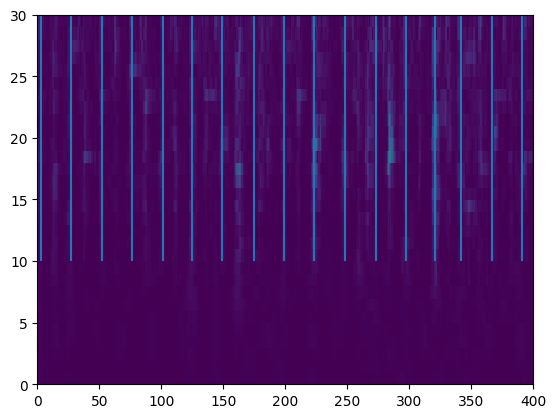

In [15]:
import matplotlib.pyplot as plt
plt.pcolor(next(iter(E_train.features['cqt_percussive']))[0])
plt.vlines(next(iter(E_train.features['beat']))[0], 10, 30)
plt.xlim(0, 400)
plt.ylim(0, 30)

Now lets calculate some basic statistics

In [16]:
Extractor.register_mapper('cqt_mean', lambda cqt: cqt.mean())
Extractor.register_mapper('cqt_var', lambda cqt: cqt.var())
Extractor.register_mapper('cqt_freq_mean', lambda cqt: cqt.mean(axis=1))
Extractor.register_mapper('cqt_freq_var', lambda cqt: cqt.var(axis=1))
Extractor.register_mapper('cqt_harmonic_mean', lambda cqt_harmonic: cqt_harmonic.mean())
Extractor.register_mapper('cqt_harmonic_var', lambda cqt_harmonic: cqt_harmonic.var())
Extractor.register_mapper('cqt_harmonic_freq_mean', lambda cqt_harmonic: cqt_harmonic.mean(axis=1))
Extractor.register_mapper('cqt_harmonic_freq_var', lambda cqt_harmonic: cqt_harmonic.var(axis=1))
Extractor.register_mapper('cqt_percussive_mean', lambda cqt_percussive: cqt_percussive.mean())
Extractor.register_mapper('cqt_percussive_var', lambda cqt_percussive: cqt_percussive.var())
Extractor.register_mapper('cqt_percussive_freq_mean', lambda cqt_percussive: cqt_percussive.mean(axis=1))
Extractor.register_mapper('cqt_percussive_freq_var', lambda cqt_percussive: cqt_percussive.var(axis=1))

# STFT has large resolution (1024 bins per frame),
# yet it is not aligned with how we hear, and lower then CQT for low frequencies.
# So we will project it in MEL bins.
Extractor.register_mapper('stft_mean', lambda stft: stft.mean(axis=1))
Extractor.register_mapper('stft_var', lambda stft: stft.var(axis=1))
Extractor.register_mapper('mel_freq_mean', lambda mel: mel.mean(axis=1))
Extractor.register_mapper('mel_freq_var', lambda mel: mel.var(axis=1))
Extractor.register_mapper('mel_harmonic_freq_mean', lambda mel_harmonic: mel_harmonic.mean(axis=1))
Extractor.register_mapper('mel_harmonic_freq_var', lambda mel_harmonic: mel_harmonic.var(axis=1))
Extractor.register_mapper('mel_percussive_freq_mean', lambda mel_percussive: mel_percussive.mean(axis=1))
Extractor.register_mapper('mel_percussive_freq_var', lambda mel_percussive: mel_percussive.var(axis=1))

In [17]:
E_train.soft_extract()
# E_eval.soft_extract()

Running extractor for features mel_freq_var at 2025-02-12 10:28:45.916415
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:28:47.837719 total running time 0:00:01.921304
Running extractor for features mel_percussive_freq_var at 2025-02-12 10:28:47.837763
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:28:48.100869 total running time 0:00:00.263106
Running extractor for features cqt_percussive_freq_mean at 2025-02-12 10:28:48.100912
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:28:48.230771 total running time 0:00:00.129859
Running extractor for features cqt_harmonic_var at 2025-02-12 10:28:48.230803
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:28:48.377027 total running time 0:00:00.146224
Running extractor for features cqt_mean at 2025-02-12 10:28:48.377060
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:28:48.474480 total running time 0:00:00.097420
Running extractor for features cqt_harmonic_freq_var at 2025-02-12 10:28:48.474515
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:28:48.669457 total running time 0:00:00.194942
Running extractor for features mel_percussive_freq_mean at 2025-02-12 10:28:48.669489
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:28:48.794389 total running time 0:00:00.124900
Running extractor for features cqt_percussive_mean at 2025-02-12 10:28:48.794422
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:28:48.897723 total running time 0:00:00.103301
Running extractor for features cqt_percussive_freq_var at 2025-02-12 10:28:48.897758
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:28:49.115151 total running time 0:00:00.217393
Running extractor for features mel_freq_mean at 2025-02-12 10:28:49.115187
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:28:49.239182 total running time 0:00:00.123995
Running extractor for features mel_harmonic_freq_mean at 2025-02-12 10:28:49.239221
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:28:49.484366 total running time 0:00:00.245145
Running extractor for features cqt_harmonic_mean at 2025-02-12 10:28:49.484403
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:28:49.578900 total running time 0:00:00.094497
Running extractor for features stft_var at 2025-02-12 10:28:49.578935
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:29:11.932836 total running time 0:00:22.353901
Running extractor for features stft_mean at 2025-02-12 10:29:11.932916
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:29:12.923732 total running time 0:00:00.990816
Running extractor for features mel_harmonic_freq_var at 2025-02-12 10:29:12.923777
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:29:13.236253 total running time 0:00:00.312476
Running extractor for features cqt_harmonic_freq_mean at 2025-02-12 10:29:13.236285
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:29:13.455636 total running time 0:00:00.219351
Running extractor for features cqt_percussive_var at 2025-02-12 10:29:13.455673
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:29:13.686490 total running time 0:00:00.230817
Running extractor for features cqt_freq_mean at 2025-02-12 10:29:13.686541
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:29:13.820897 total running time 0:00:00.134356
Running extractor for features cqt_var at 2025-02-12 10:29:13.820941
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:29:14.070939 total running time 0:00:00.249998
Running extractor for features cqt_freq_var at 2025-02-12 10:29:14.070974
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:29:14.344294 total running time 0:00:00.273320


In [18]:
features = ['cqt_freq_mean', 'cqt_freq_var', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var']

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features),
    y=y_train.to_numpy(),
)

0:	learn: 0.2895149	total: 134ms	remaining: 1m 6s
100:	learn: 0.7965571	total: 1.92s	remaining: 7.59s
200:	learn: 0.8748044	total: 3.6s	remaining: 5.36s
300:	learn: 0.9374022	total: 5.38s	remaining: 3.56s
400:	learn: 0.9640063	total: 7.17s	remaining: 1.77s
499:	learn: 0.9874804	total: 8.94s	remaining: 0us
0:	learn: 0.3004695	total: 31.2ms	remaining: 15.6s
100:	learn: 0.7918623	total: 2.08s	remaining: 8.23s
200:	learn: 0.8935837	total: 3.85s	remaining: 5.72s
300:	learn: 0.9264476	total: 5.54s	remaining: 3.67s
400:	learn: 0.9640063	total: 7.22s	remaining: 1.78s
499:	learn: 0.9859155	total: 8.89s	remaining: 0us
0:	learn: 0.3004695	total: 28.3ms	remaining: 14.1s
100:	learn: 0.7809077	total: 1.75s	remaining: 6.89s
200:	learn: 0.8873239	total: 3.46s	remaining: 5.15s
300:	learn: 0.9311424	total: 5.12s	remaining: 3.38s
400:	learn: 0.9640063	total: 6.77s	remaining: 1.67s
499:	learn: 0.9765258	total: 8.41s	remaining: 0us
0:	learn: 0.2456964	total: 27.5ms	remaining: 13.7s
100:	learn: 0.7762128	to

In [19]:
Extractor.register_mapper('mfcc_quef_mean', lambda mfcc: mfcc.mean(axis=1))
Extractor.register_mapper('mfcc_quef_var', lambda mfcc: mfcc.var(axis=1))

# Usually STFT is used for spectral centroid, but I will use CQT, it may turn out to be even more precise.
cqt_frequencies = librosa.cqt_frequencies(n_bins=n_bins, fmin=fmin, bins_per_octave=bins_per_octave)
# Extractor.register_extractor('cqt_spectral_centroid',
#                              lambda cqt: np.sum(cqt_frequencies.reshape(-1, 1) * librosa.util.normalize(cqt, norm=1, axis=0), axis=0))
Extractor.register_mapper('spectral_centroid',
                             lambda audio: librosa.feature.spectral_centroid(y=audio, sr=sr))

Extractor.register_mapper('spectral_centroid_mean', lambda spectral_centroid: spectral_centroid.mean())
Extractor.register_mapper('spectral_centroid_var', lambda spectral_centroid: spectral_centroid.var())

cqt_frequencies = librosa.cqt_frequencies(n_bins=n_bins, fmin=fmin, bins_per_octave=bins_per_octave)
chroma_map = librosa.filters.cq_to_chroma(cqt_frequencies.shape[0], bins_per_octave=bins_per_octave, n_chroma=bins_per_octave, fmin=fmin)
Extractor.register_mapper('cqt_chroma',
                             lambda cqt: librosa.feature.chroma_cqt(C=cqt, sr=sr, hop_length=hop_length, fmin=fmin))
Extractor.register_mapper('cqt_chroma_freq_mean', lambda cqt_chroma: cqt_chroma.mean(axis=1))
Extractor.register_mapper('cqt_chroma_freq_var', lambda cqt_chroma: cqt_chroma.var(axis=1))
Extractor.register_mapper('cqt_chroma_mean', lambda cqt_chroma: cqt_chroma.mean())
Extractor.register_mapper('cqt_chroma_var', lambda cqt_chroma: cqt_chroma.var())

Extractor.register_mapper('cqt_harmonic_chroma',
                             lambda cqt_harmonic: librosa.feature.chroma_cqt(C=cqt_harmonic, sr=sr, hop_length=hop_length, fmin=fmin))
Extractor.register_mapper('cqt_harmonic_chroma_freq_mean', lambda cqt_harmonic_chroma: cqt_harmonic_chroma.mean(axis=1))
Extractor.register_mapper('cqt_harmonic_chroma_freq_var', lambda cqt_harmonic_chroma: cqt_harmonic_chroma.var(axis=1))
Extractor.register_mapper('cqt_harmonic_chroma_mean', lambda cqt_harmonic_chroma: cqt_harmonic_chroma.mean())
Extractor.register_mapper('cqt_harmonic_chroma_var', lambda cqt_harmonic_chroma: cqt_harmonic_chroma.var())

roll_percent = 0.85
# Extractor.register_extractor('cqt_rolloff',
#                              lambda cqt: librosa.feature.spectral.spectral_rolloff(S=cqt, freq=cqt_frequencies, roll_percent=roll_percent))
Extractor.register_mapper('rolloff',
                             lambda stft: librosa.feature.spectral.spectral_rolloff(S=stft, sr=sr, roll_percent=roll_percent))

Extractor.register_mapper('rolloff_mean', lambda rolloff: rolloff.mean())
Extractor.register_mapper('rolloff_var', lambda rolloff: rolloff.var())

# Extractor.register_extractor('cqt_bandwidth',
#                              lambda cqt: librosa.feature.spectral.spectral_bandwidth(S=cqt, freq=cqt_frequencies))
Extractor.register_mapper('bandwidth',
                             lambda stft: librosa.feature.spectral.spectral_bandwidth(S=stft, sr=sr, n_fft=n_fft))

Extractor.register_mapper('bandwidth_mean', lambda bandwidth: bandwidth.mean())
Extractor.register_mapper('bandwidth_var', lambda bandwidth: bandwidth.var())

Extractor.register_mapper('zero_crossing_rate',
                             lambda audio: librosa.feature.zero_crossing_rate(y=audio))

Extractor.register_mapper('zero_crossing_rate_mean', lambda zero_crossing_rate: zero_crossing_rate.mean())
Extractor.register_mapper('zero_crossing_rate_var', lambda zero_crossing_rate: zero_crossing_rate.var())


Extractor.register_mapper('percept', lambda cqt: librosa.perceptual_weighting(cqt**2, cqt_frequencies, ref=np.max))
Extractor.register_mapper('percept_freq_mean', lambda percept: percept.mean(axis=1))
Extractor.register_mapper('percept_freq_var', lambda percept: percept.var(axis=1))
Extractor.register_mapper('percept_mean', lambda percept: percept.mean())
Extractor.register_mapper('percept_var', lambda percept: percept.var())

Extractor.register_mapper('stft_chroma', lambda stft: librosa.feature.chroma_stft(S=stft**2, sr=sr))
Extractor.register_mapper('stft_chroma_freq_mean', lambda stft_chroma: np.mean(stft_chroma, axis=1))
Extractor.register_mapper('stft_chroma_freq_var', lambda stft_chroma: np.var(stft_chroma, axis=1))
Extractor.register_mapper('stft_chroma_mean', lambda stft_chroma: np.mean(stft_chroma))
Extractor.register_mapper('stft_chroma_var', lambda stft_chroma: np.var(stft_chroma))

In [20]:
E_train.soft_extract()
# E_eval.soft_extract()

Running extractor for features percept at 2025-02-12 10:30:06.747622
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:30:08.601091 total running time 0:00:01.853469
Running extractor for features percept_var at 2025-02-12 10:30:08.601126
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:30:08.885833 total running time 0:00:00.284707
Running extractor for features cqt_chroma at 2025-02-12 10:30:08.885866
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:30:10.049980 total running time 0:00:01.164114
Running extractor for features cqt_chroma_freq_mean at 2025-02-12 10:30:10.050062
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:30:10.432782 total running time 0:00:00.382720
Running extractor for features stft_chroma at 2025-02-12 10:30:10.432817
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:30:32.827180 total running time 0:00:22.394363
Running extractor for features stft_chroma_freq_var at 2025-02-12 10:30:32.827216
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:30:33.211671 total running time 0:00:00.384455
Running extractor for features spectral_centroid at 2025-02-12 10:30:33.211703
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:30:51.850036 total running time 0:00:18.638333
Running extractor for features spectral_centroid_var at 2025-02-12 10:30:51.850133
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:30:52.126843 total running time 0:00:00.276710
Running extractor for features percept_mean at 2025-02-12 10:30:52.126875
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:30:52.425323 total running time 0:00:00.298448
Running extractor for features rolloff at 2025-02-12 10:30:52.425365
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:30:59.544027 total running time 0:00:07.118662
Running extractor for features rolloff_mean at 2025-02-12 10:30:59.544069
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:30:59.825567 total running time 0:00:00.281498
Running extractor for features mfcc_quef_mean at 2025-02-12 10:30:59.825600
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:00.633011 total running time 0:00:00.807411
Running extractor for features cqt_harmonic_chroma at 2025-02-12 10:31:00.633050
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:02.397253 total running time 0:00:01.764203
Running extractor for features cqt_harmonic_chroma_mean at 2025-02-12 10:31:02.397332
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:02.855659 total running time 0:00:00.458327
Running extractor for features bandwidth at 2025-02-12 10:31:02.855698
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:15.642511 total running time 0:00:12.786813
Running extractor for features bandwidth_var at 2025-02-12 10:31:15.642564
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:15.981200 total running time 0:00:00.338636
Running extractor for features spectral_centroid_mean at 2025-02-12 10:31:15.981231
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:16.202991 total running time 0:00:00.221760
Running extractor for features cqt_harmonic_chroma_freq_mean at 2025-02-12 10:31:16.203023
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:16.500626 total running time 0:00:00.297603
Running extractor for features percept_freq_var at 2025-02-12 10:31:16.500659
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:16.858070 total running time 0:00:00.357411
Running extractor for features cqt_chroma_var at 2025-02-12 10:31:16.858104
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:17.046368 total running time 0:00:00.188264
Running extractor for features bandwidth_mean at 2025-02-12 10:31:17.046405
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:17.319157 total running time 0:00:00.272752
Running extractor for features cqt_chroma_freq_var at 2025-02-12 10:31:17.319189
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:17.665987 total running time 0:00:00.346798
Running extractor for features cqt_harmonic_chroma_var at 2025-02-12 10:31:17.666017
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:17.969316 total running time 0:00:00.303299
Running extractor for features mfcc_quef_var at 2025-02-12 10:31:17.969348
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:18.220176 total running time 0:00:00.250828
Running extractor for features zero_crossing_rate at 2025-02-12 10:31:18.220211
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:23.350478 total running time 0:00:05.130267
Running extractor for features zero_crossing_rate_mean at 2025-02-12 10:31:23.350513
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:23.707241 total running time 0:00:00.356728
Running extractor for features stft_chroma_mean at 2025-02-12 10:31:23.707272
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:23.890254 total running time 0:00:00.182982
Running extractor for features zero_crossing_rate_var at 2025-02-12 10:31:23.890286
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:24.245653 total running time 0:00:00.355367
Running extractor for features percept_freq_mean at 2025-02-12 10:31:24.245688
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:24.575138 total running time 0:00:00.329450
Running extractor for features rolloff_var at 2025-02-12 10:31:24.575170
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:24.748615 total running time 0:00:00.173445
Running extractor for features stft_chroma_freq_mean at 2025-02-12 10:31:24.748641
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:25.069555 total running time 0:00:00.320914
Running extractor for features stft_chroma_var at 2025-02-12 10:31:25.069587
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:25.451781 total running time 0:00:00.382194
Running extractor for features cqt_harmonic_chroma_freq_var at 2025-02-12 10:31:25.451812
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:25.730470 total running time 0:00:00.278658
Running extractor for features cqt_chroma_mean at 2025-02-12 10:31:25.730500
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:31:25.977986 total running time 0:00:00.247486


In [21]:
features = ['rms', 'bpm',
    'cqt_freq_mean', 'cqt_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean']

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features),
    y=y_train.to_numpy(),
)

0:	learn: 0.3067293	total: 45.5ms	remaining: 22.7s
100:	learn: 0.8669797	total: 2.77s	remaining: 10.9s
200:	learn: 0.9405321	total: 5.31s	remaining: 7.9s
300:	learn: 0.9733959	total: 7.81s	remaining: 5.17s
400:	learn: 0.9906103	total: 10.4s	remaining: 2.56s
499:	learn: 0.9968701	total: 12.8s	remaining: 0us
0:	learn: 0.3255086	total: 42.7ms	remaining: 21.3s
100:	learn: 0.8685446	total: 2.61s	remaining: 10.3s
200:	learn: 0.9405321	total: 5.1s	remaining: 7.58s
300:	learn: 0.9765258	total: 7.56s	remaining: 5s
400:	learn: 0.9874804	total: 10s	remaining: 2.47s
499:	learn: 0.9937402	total: 12.4s	remaining: 0us
0:	learn: 0.2957746	total: 41.8ms	remaining: 20.9s
100:	learn: 0.8669797	total: 2.6s	remaining: 10.3s
200:	learn: 0.9420970	total: 5.12s	remaining: 7.62s
300:	learn: 0.9718310	total: 7.64s	remaining: 5.05s
400:	learn: 0.9890454	total: 10.1s	remaining: 2.5s
499:	learn: 0.9921753	total: 12.5s	remaining: 0us
0:	learn: 0.3114241	total: 41.4ms	remaining: 20.7s
100:	learn: 0.8450704	total: 2.

In [22]:
features = ['rms', 'bpm',
    'mel_freq_mean', 'mel_freq_var',
    'stft_harmonic_mean', 'mel_harmonic_freq_mean', 'mel_harmonic_freq_var',
    'stft_percussive_mean', 'mel_percussive_freq_mean', 'mel_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean']

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features),
    y=y_train.to_numpy(),
)

0:	learn: 0.2926448	total: 82.3ms	remaining: 41.1s
100:	learn: 0.8669797	total: 3.96s	remaining: 15.6s
200:	learn: 0.9436620	total: 7.46s	remaining: 11.1s
300:	learn: 0.9796557	total: 11s	remaining: 7.29s
400:	learn: 0.9921753	total: 14.4s	remaining: 3.55s
499:	learn: 0.9984351	total: 17.7s	remaining: 0us
0:	learn: 0.3286385	total: 55.7ms	remaining: 27.8s
100:	learn: 0.8482003	total: 3.74s	remaining: 14.8s
200:	learn: 0.9452269	total: 7.14s	remaining: 10.6s
300:	learn: 0.9687011	total: 10.5s	remaining: 6.96s
400:	learn: 0.9906103	total: 13.9s	remaining: 3.44s
499:	learn: 0.9953052	total: 17.6s	remaining: 0us
0:	learn: 0.3442879	total: 60.7ms	remaining: 30.3s
100:	learn: 0.8575900	total: 3.84s	remaining: 15.2s
200:	learn: 0.9327074	total: 7.44s	remaining: 11.1s
300:	learn: 0.9671362	total: 11s	remaining: 7.29s
400:	learn: 0.9874804	total: 14.4s	remaining: 3.54s
499:	learn: 0.9921753	total: 17.7s	remaining: 0us
0:	learn: 0.3082942	total: 56ms	remaining: 27.9s
100:	learn: 0.8153365	total:

In [23]:
n_mels = 48
mel_proj = librosa.filters.mel(sr=sr, n_fft=n_fft, fmin=fmin, fmax=fmax, n_mels=n_mels)

In [24]:
Extractor.register_mapper('mel48', lambda stft: librosa.power_to_db(np.einsum("ij,jk->ik", mel_proj, stft**2, optimize=True)))
def mel_hpss(stft_harmonic, stft_percussive):
    return (
        librosa.power_to_db(np.einsum("ij,jk->ik", mel_proj, stft_harmonic**2, optimize=True)),
        librosa.power_to_db(np.einsum("ij,jk->ik", mel_proj, stft_percussive**2, optimize=True)),
    )

Extractor.register_mapper(['mel48_harmonic', 'mel48_percussive'], mel_hpss)
E_train.soft_extract()

Running extractor for features mel48_harmonic, mel48_percussive at 2025-02-12 10:34:32.263034
Failed compiling function, will use plain python wrapper, exception: can only concatenate list (not "tuple") to list


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:35:27.033773 total running time 0:00:54.770739
Running extractor for features mel48 at 2025-02-12 10:35:27.035286
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:35:59.927544 total running time 0:00:32.892258


In [25]:
Extractor.register_mapper('mel48_freq_mean', lambda mel48: mel48.mean(axis=1))
Extractor.register_mapper('mel48_freq_var', lambda mel48: mel48.var(axis=1))
Extractor.register_mapper('mel48_harmonic_freq_mean', lambda mel48_harmonic: mel48_harmonic.mean(axis=1))
Extractor.register_mapper('mel48_harmonic_freq_var', lambda mel48_harmonic: mel48_harmonic.var(axis=1))
Extractor.register_mapper('mel48_percussive_freq_mean', lambda mel48_percussive: mel48_percussive.mean(axis=1))
Extractor.register_mapper('mel48_percussive_freq_var', lambda mel48_percussive: mel48_percussive.var(axis=1))
E_train.soft_extract()

Running extractor for features mel48_percussive_freq_var at 2025-02-12 10:35:59.955811
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:36:00.661154 total running time 0:00:00.705343
Running extractor for features mel48_freq_mean at 2025-02-12 10:36:00.661189
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:36:00.787352 total running time 0:00:00.126163
Running extractor for features mel48_harmonic_freq_mean at 2025-02-12 10:36:00.787386
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:36:01.480861 total running time 0:00:00.693475
Running extractor for features mel48_harmonic_freq_var at 2025-02-12 10:36:01.480897
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:36:01.617698 total running time 0:00:00.136801
Running extractor for features mel48_percussive_freq_mean at 2025-02-12 10:36:01.617736
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:36:01.693427 total running time 0:00:00.075691
Running extractor for features mel48_freq_var at 2025-02-12 10:36:01.693465
Failed compiling function, will use plain python wrapper.


  0%|          | 0/799 [00:00<?, ?it/s]

Done running extractor at 2025-02-12 10:36:01.790050 total running time 0:00:00.096585


In [26]:
features = ['rms', 'bpm',
    'mel48_freq_mean', 'mel48_freq_var',
    'stft_harmonic_mean', 'mel48_harmonic_freq_mean', 'mel48_harmonic_freq_var',
    'stft_percussive_mean', 'mel48_percussive_freq_mean', 'mel48_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean']

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features),
    y=y_train.to_numpy(),
)

0:	learn: 0.2863850	total: 61.1ms	remaining: 30.5s
100:	learn: 0.8607199	total: 1.97s	remaining: 7.8s
200:	learn: 0.9327074	total: 3.84s	remaining: 5.71s
300:	learn: 0.9718310	total: 5.68s	remaining: 3.76s
400:	learn: 0.9874804	total: 7.51s	remaining: 1.85s
499:	learn: 0.9984351	total: 9.31s	remaining: 0us
0:	learn: 0.2989045	total: 32.7ms	remaining: 16.3s
100:	learn: 0.8748044	total: 2.04s	remaining: 8.06s
200:	learn: 0.9327074	total: 4.03s	remaining: 5.99s
300:	learn: 0.9733959	total: 6.06s	remaining: 4.01s
400:	learn: 0.9859155	total: 8.2s	remaining: 2.02s
499:	learn: 0.9921753	total: 10.1s	remaining: 0us
0:	learn: 0.2989045	total: 31.1ms	remaining: 15.5s
100:	learn: 0.8528951	total: 1.96s	remaining: 7.76s
200:	learn: 0.9342723	total: 3.92s	remaining: 5.83s
300:	learn: 0.9733959	total: 5.79s	remaining: 3.83s
400:	learn: 0.9843505	total: 7.72s	remaining: 1.91s
499:	learn: 0.9921753	total: 9.63s	remaining: 0us
0:	learn: 0.2942097	total: 34.3ms	remaining: 17.1s
100:	learn: 0.8528951	to

In [27]:
pd.DataFrame(
    data=model.feature_importances_,
    index=E_train.get_columns(features),
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)

,importance
mfcc_quef_mean_3,2.604016
mfcc_quef_mean_5,2.526090
bandwidth_mean,2.522673
mel48_percussive_freq_var_1,2.423438
mel48_percussive_freq_var_0,2.334968
mfcc_quef_var_4,2.315471
rms,1.781317
spectral_centroid_var,1.599715
percept_freq_var_1,1.565962
mfcc_quef_mean_8,1.362403


In [84]:
features = ['rms', 'bpm',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean']

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features),
    y=y_train.to_numpy(),
)

0:	learn: 0.3145540	total: 43.3ms	remaining: 21.6s
100:	learn: 0.8560250	total: 2.57s	remaining: 10.2s
200:	learn: 0.9483568	total: 5s	remaining: 7.43s
300:	learn: 0.9733959	total: 7.35s	remaining: 4.86s
400:	learn: 0.9921753	total: 9.61s	remaining: 2.37s
499:	learn: 1.0000000	total: 11.8s	remaining: 0us
0:	learn: 0.2989045	total: 38.5ms	remaining: 19.2s
100:	learn: 0.8638498	total: 2.46s	remaining: 9.71s
200:	learn: 0.9436620	total: 4.92s	remaining: 7.33s
300:	learn: 0.9671362	total: 7.29s	remaining: 4.82s
400:	learn: 0.9874804	total: 9.57s	remaining: 2.36s
499:	learn: 0.9906103	total: 11.8s	remaining: 0us
0:	learn: 0.2879499	total: 36.7ms	remaining: 18.3s
100:	learn: 0.8544601	total: 2.39s	remaining: 9.45s
200:	learn: 0.9327074	total: 4.67s	remaining: 6.95s
300:	learn: 0.9608764	total: 7.09s	remaining: 4.68s
400:	learn: 0.9812207	total: 9.35s	remaining: 2.31s
499:	learn: 0.9953052	total: 11.6s	remaining: 0us
0:	learn: 0.2973396	total: 38ms	remaining: 19s
100:	learn: 0.8435055	total: 

In [29]:
pd.DataFrame(
    data=model.feature_importances_,
    index=E_train.get_columns(features),
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)

,importance
cqt_percussive_freq_var_5,2.752950
mfcc_quef_var_4,1.861032
rolloff_var,1.830884
mfcc_quef_mean_3,1.636252
cqt_percussive_freq_var_24,1.595311
mfcc_quef_mean_5,1.549922
cqt_percussive_freq_var_28,1.436959
mfcc_quef_mean_8,1.400779
bandwidth_mean,1.386569
percept_freq_mean_64,1.369409


In [30]:
pd.DataFrame(
    data=model.feature_importances_,
    index=E_train.get_columns(features),
    columns=['importance']
).sort_values(by='importance', ascending=True).head(30)

,importance
rms,0.0
cqt_percussive_freq_mean_67,0.0
cqt_percussive_freq_mean_66,0.0
cqt_percussive_freq_mean_63,0.0
cqt_percussive_freq_mean_62,0.0
cqt_percussive_freq_mean_61,0.0
cqt_percussive_freq_mean_60,0.0
cqt_percussive_freq_mean_59,0.0
cqt_percussive_freq_mean_58,0.0
cqt_percussive_freq_mean_57,0.0


In [31]:
df = pd.DataFrame(
    data=model.feature_importances_,
    index=E_train.get_columns(features),
    columns=['importance']
)
df.loc[pd.Series(df.index, index=df.index).apply(lambda x: x.startswith('cqt_percussive'))].sort_values('importance', ascending=False).head(30)

,importance
cqt_percussive_freq_var_5,2.752950
cqt_percussive_freq_var_24,1.595311
cqt_percussive_freq_var_28,1.436959
cqt_percussive_freq_mean_14,1.207290
cqt_percussive_freq_var_20,0.892143
cqt_percussive_freq_var_29,0.867401
cqt_percussive_freq_var_36,0.785187
cqt_percussive_freq_mean_30,0.703420
cqt_percussive_freq_var_23,0.654190
cqt_percussive_freq_var_26,0.637286


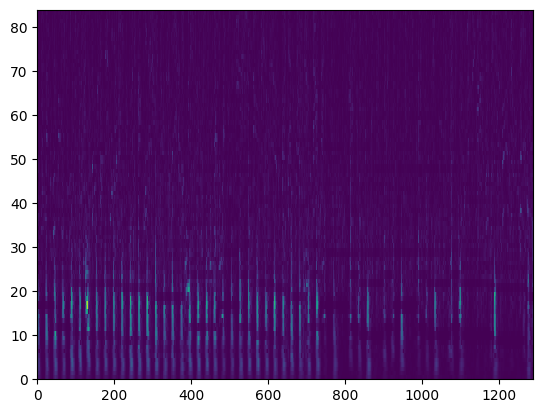

In [32]:
import matplotlib.pyplot as plt
i = iter(E_train.features['cqt_percussive'])
next(i)
plt.pcolor(next(i)[0])

In [ ]:
# import importlib
# train_and_evaluate_catboost = importlib.reload(importlib.import_module("model")).train_and_evaluate_catboost

In [ ]:
# import optuna

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# features = ['rms', 'bpm',
#     'mel48_freq_mean', 'mel48_freq_var',
#     'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
#     'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
#     'mfcc_quef_mean', 'mfcc_quef_var',
#     'spectral_centroid_mean', 'spectral_centroid_var',
#     'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
#     'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
#     'rolloff_mean', 'rolloff_var',
#     'bandwidth_mean', 'bandwidth_var',
#     'percept_freq_mean', 'percept_freq_var',
#     'zero_crossing_rate_mean']

# all_features = ['rms', 'bpm',
#     'mel_freq_mean', 'mel_freq_var',
#     'mel48_freq_mean', 'mel48_freq_var',
#     'cqt_freq_mean', 'cqt_freq_var',
#     'stft_harmonic_mean', 'stft_harmonic_var', 'mel_harmonic_freq_mean', 'mel_harmonic_freq_var', 'mel48_harmonic_freq_mean', 'mel48_harmonic_freq_var',
#     'cqt_harmonic_mean', 'cqt_harmonic_var', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
#     'stft_percussive_mean', 'stft_percussive_var', 'mel_percussive_freq_mean', 'mel_percussive_freq_var', 'mel48_percussive_freq_mean', 'mel48_percussive_freq_var',
#     'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
#     'mfcc_quef_mean', 'mfcc_quef_var',
#     'spectral_centroid_mean', 'spectral_centroid_var',
#     'stft_chroma_mean', 'stft_chroma_var', 'stft_chroma_freq_mean', 'stft_chroma_freq_var',
#     'cqt_chroma_mean', 'cqt_chroma_var', 'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
#     'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
#     'rolloff_mean', 'rolloff_var',
#     'bandwidth_mean', 'bandwidth_var',
#     'percept_freq_mean', 'percept_freq_var',
#     'zero_crossing_rate_mean', 'zero_crossing_rate_var']

# def objective(trial, X, y, column_names):
#     num_features = X.shape[1]
#     selected_features = [trial.suggest_categorical(column_names[i], [0, 1]) for i in range(num_features)]
#     selected_features = np.array(selected_features, dtype=bool)
    
#     if np.sum(selected_features) == 0:
#         return 0  # Avoid empty feature selection

#     X = X[:, selected_features]
    
#     _, acc = train_and_evaluate_catboost(X, y, verbose=False, train_final=False)
#     return acc

# def feature_selection_with_optuna(X, y, column_names, initial_features, n_trials=50):
#     study = optuna.create_study(direction='maximize', storage="sqlite:///optuna.db")
#     if initial_features is not None:
#         initial_params = {c: int(c in initial_features) for c in column_names}
#         study.enqueue_trial(initial_params)
#     study.optimize(lambda trial: objective(trial, X, y, column_names), n_trials=n_trials)
    
#     best_features = [i for i in range(X.shape[1]) if study.best_trial.params.get(column_names[i], 0) == 1]
#     return best_features, study.best_value

# best_features, best_value = feature_selection_with_optuna(
#     E_train.numpy(all_features),
#     y_train.to_numpy(),
#     column_names=E_train.get_columns(all_features),
#     initial_features=E_train.get_columns(features)
# )

In [85]:
imp = pd.DataFrame(
    data=model.feature_importances_,
    index=E_train.get_columns(features),
    columns=['importance']
)
bad_feats = list(imp[imp['importance'] < 0.1].index)

In [34]:
features = ['rms', 'bpm',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean']

column_names = E_train.get_columns(features)
mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

0:	learn: 0.3239437	total: 14.8ms	remaining: 7.38s
100:	learn: 0.8669797	total: 875ms	remaining: 3.46s
200:	learn: 0.9546166	total: 1.68s	remaining: 2.5s
300:	learn: 0.9702660	total: 2.53s	remaining: 1.67s
400:	learn: 0.9906103	total: 3.37s	remaining: 831ms
499:	learn: 0.9968701	total: 4.2s	remaining: 0us
0:	learn: 0.3505477	total: 13.5ms	remaining: 6.73s
100:	learn: 0.8810642	total: 874ms	remaining: 3.45s
200:	learn: 0.9358372	total: 1.67s	remaining: 2.48s
300:	learn: 0.9671362	total: 2.48s	remaining: 1.64s
400:	learn: 0.9812207	total: 3.28s	remaining: 811ms
499:	learn: 0.9906103	total: 4.09s	remaining: 0us
0:	learn: 0.2989045	total: 13.4ms	remaining: 6.69s
100:	learn: 0.8716745	total: 886ms	remaining: 3.5s
200:	learn: 0.9420970	total: 1.74s	remaining: 2.58s
300:	learn: 0.9733959	total: 2.53s	remaining: 1.67s
400:	learn: 0.9859155	total: 3.29s	remaining: 813ms
499:	learn: 0.9921753	total: 4.06s	remaining: 0us
0:	learn: 0.2456964	total: 12.9ms	remaining: 6.44s
100:	learn: 0.8654147	tot

In [35]:
import numpy as np
import librosa

p_pitch_stay=0.6
p_pitch_to_silence=0.3
p_silence_stay=0.8
win_size=3
base_weight=1.0
tri_weight=2.0
energy_scale=0.5
harmonic_weights=[0.8, 0.6, 0.4]
eps=1e-6

import numpy as np
import librosa

def compute_f0_from_cqt(cqt):
    """
    Estimate the fundamental frequency (f0) from a CQT spectrogram using Viterbi decoding,
    incorporating:
      (a) a silence state with frame-dependent observation probability,
      (b) a custom transition matrix with a constant plus triangular smoothing, and
      (c) a harmonic weighting scheme that boosts candidate pitch observations if overtones are present.
    
    Observation probabilities:
      - For each frame, silence probability is computed from the original frame energy as:
            silence_obs_prob = 1/(1 + (frame_energy/energy_scale))
      - For pitch states, the CQT magnitudes are first “boosted” by adding weighted contributions
        from overtones. For each candidate state (bin i with center frequency f[i]):
            weighted_cqt[i,t] = cqt_spec[i,t] + sum_{k=2}^{K} (h[k-2] * cqt_spec[j,t])
        where j is the index whose center frequency is closest to k*f[i] and K is the maximum harmonic
        for which k*f[i] is within the range of cqt_frequencies.
      - The boosted magnitudes for pitch states are normalized per frame and then scaled by (1 – silence_obs_prob[t]).
      - The silence observation probability (computed per frame) is appended as the extra state.
    
    Transition matrix for states:
      - For pitch states (indices 0 to n_bins-1):
           • Self-transition probability is p_pitch_stay.
           • A fixed probability p_pitch_to_silence is allocated for transitions to silence.
           • The remaining mass (1 – p_pitch_stay – p_pitch_to_silence) is distributed among transitions to
             other pitch states using a smoothing function:
               weight(i -> j) = base_weight + (if |i – j| <= win_size then tri_weight * (win_size – |i – j| + 1) else 0)
             (These raw weights are normalized to sum to the available probability mass.)
      - For the silence state (index n_bins):
           • Self-transition probability is p_silence_stay.
           • Transitions from silence to any pitch state are uniform.
    
    Parameters:
        cqt_spec (np.ndarray): 2D array (n_bins x n_frames) with the magnitude CQT spectrogram.
        cqt_frequencies (np.ndarray): 1D array (length n_bins) of center frequencies for the CQT bins.
        p_pitch_stay (float): Probability of remaining in the same pitch state.
        p_pitch_to_silence (float): Probability of transitioning from a pitch state to silence.
        p_silence_stay (float): Self-transition probability for the silence state.
        win_size (int): Window size (in bins) for the triangular smoothing component.
        base_weight (float): Baseline weight for transitions between different pitch states.
        tri_weight (float): Additional weight for transitions to nearby notes within win_size.
        energy_scale (float): Scaling factor for computing silence probability from frame energy.
        harmonic_weights (list of float): List of weights for overtones (starting with the 2nd harmonic).
        eps (float): Small constant to avoid division by zero.
    
    Returns:
        f0 (np.ndarray): 1D array (n_frames) of estimated f0 in Hz (0 for silent frames).
        f0_bins (np.ndarray): 1D array (n_frames) with the index of the chosen pitch bin (-1 for silence).
        voiced (np.ndarray): 1D boolean array (n_frames), True if the frame is voiced.
    """
    n_bins, n_frames = cqt.shape
    n_states = n_bins + 1  # extra state for silence
    silence_state = n_bins

    # --- Compute frame energy and silence observation probability ---
    frame_energy = np.sum(cqt, axis=0)  # energy per frame
    silence_obs_prob = 1.0 / (1.0 + (frame_energy / energy_scale))  # higher when energy is low

    # --- Harmonic weighting of pitch observations ---
    # Create a weighted version of the CQT magnitudes so that each candidate's observation is boosted by its overtones.
    weighted_cqt = np.empty_like(cqt)
    for i in range(n_bins):
        # Start with the fundamental magnitude.
        # weighted_cqt[i, t] = cqt_spec[i, t] plus contributions from overtones.
        weighted = cqt[i, :].copy()
        f0_candidate = cqt_frequencies[i]
        # Iterate over harmonics k=2,3,...
        for k, weight in enumerate(harmonic_weights, start=2):
            f_harm = k * f0_candidate
            # If the harmonic frequency exceeds the max frequency in our CQT, stop.
            if f_harm > cqt_frequencies[-1]:
                break
            # Find the bin whose center frequency is closest to the expected harmonic frequency.
            j = np.argmin(np.abs(cqt_frequencies - f_harm))
            # Add the weighted energy from the overtone.
            weighted += weight * cqt[j, :]
        weighted_cqt[i, :] = weighted
    weighted_cqt = weighted_cqt * np.log(10 + np.arange(n_bins))[:, None]
    # --- Build the observation (emission) probability matrix ---
    # For each frame, normalize the weighted pitch observations.
    sum_weighted = np.sum(weighted_cqt, axis=0, keepdims=True) + eps
    # Pitch observation probabilities scaled by (1 - silence_obs_prob).
    obs_pitch = weighted_cqt / sum_weighted * (1 - silence_obs_prob[None, :])
    # Silence observation probabilities (shape: 1 x n_frames)
    obs_silence = silence_obs_prob[None, :]
    # Combined observation matrix: shape (n_states, n_frames), each column sums to 1.
    obs_probs = np.vstack([obs_pitch, obs_silence])
    
    # --- Build the transition probability matrix ---
    transition = np.zeros((n_states, n_states), dtype=np.float64)
    
    # For each pitch state (indices 0 to n_bins-1):
    for i in range(n_bins):
        # Self-transition: remain on the same note.
        transition[i, i] = p_pitch_stay

        # Compute raw weights for transitions to other pitch states.
        raw_weights = np.zeros(n_bins, dtype=np.float64)
        for j in range(n_bins):
            if j == i:
                continue
            # Distance between candidate states.
            dist = abs(i - j)
            # Triangular component if within win_size.
            if dist <= win_size:
                tri_comp = tri_weight * (win_size - dist + 1)
            else:
                tri_comp = 0.0
            raw_weights[j] = base_weight + tri_comp

        # Total probability mass available for transitions to other pitch states.
        avail_mass = 1 - p_pitch_stay - p_pitch_to_silence
        if raw_weights.sum() > 0:
            raw_weights = raw_weights / raw_weights.sum() * avail_mass
        else:
            raw_weights[:] = avail_mass / (n_bins - 1)
        # Assign probabilities for transitioning from pitch state i to other pitch states.
        for j in range(n_bins):
            if j != i:
                transition[i, j] = raw_weights[j]
        # Transition probability from pitch state i to silence.
        transition[i, silence_state] = p_pitch_to_silence

    # For the silence state:
    # Transition from silence to any pitch state uniformly.
    transition[silence_state, :n_bins] = (1 - p_silence_stay) / n_bins
    # Self-transition for silence.
    transition[silence_state, silence_state] = p_silence_stay

    # --- Run the Viterbi algorithm ---
    # librosa.sequence.viterbi expects 1-normalized probabilities; it will take the logarithm internally.
    best_path = librosa.sequence.viterbi(obs_probs, transition)

    # --- Post-processing: interpret state sequence ---
    # Pitch states are indices 0 ... n_bins-1; silence is indicated by state n_bins.
    voiced = best_path < n_bins
    f0_bins = np.where(voiced, best_path, -1)
    f0 = np.zeros(n_frames, dtype=np.float64)
    f0[voiced] = cqt_frequencies[best_path[voiced]]

    return f0, f0_bins, voiced

In [36]:
f0, f0_bins, voiced = compute_f0_from_cqt(next(iter(E_train.features['cqt']))[0])

In [ ]:
# f0_pyin, voiced, _ = librosa.pyin(next(iter(E_train.features['audio']))[0], sr=sr, fmin=fmin, fmax=fmax)

In [ ]:
# f0_pyin[~voiced] = -1

In [ ]:
# spec.shape

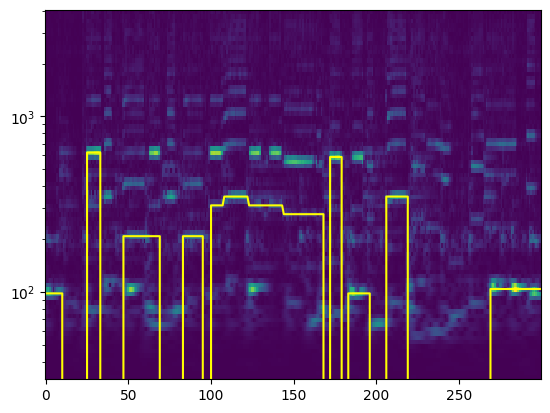

In [40]:
spec = next(iter(E_train.features['cqt']))[0][:,100:400]
x = cqt_frequencies
y = np.arange(spec.shape[1])
xx, yy = np.meshgrid(y, x)
plt.pcolor(xx, yy, spec)
plt.plot(f0[100:400], color='yellow')
# plt.plot(f0_pyin[100:400], color='red')
plt.yscale('log')

In [38]:
Extractor.register_mapper(['f0', 'f0_bins', 'voiced'], compute_f0_from_cqt)
Extractor.register_mapper('f0_mean', lambda f0: np.mean(f0))
Extractor.register_mapper('f0_var', lambda f0: np.var(f0))
Extractor.register_mapper('voiced_f0', lambda f0, voiced: f0[voiced], uniform=False)
Extractor.register_mapper('voiced_f0_mean', lambda f0: np.mean(f0))
Extractor.register_mapper('voiced_f0_var', lambda f0: np.var(f0))
Extractor.register_mapper('voiced_percent', lambda voiced: np.mean(voiced))

In [41]:
E_train.soft_extract()

In [86]:
features = ['rms', 'bpm', 'zero_crossing_rate_mean',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent']

column_names = E_train.get_columns(features)
mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

0:	learn: 0.2848200	total: 13.1ms	remaining: 6.54s
100:	learn: 0.8669797	total: 822ms	remaining: 3.25s
200:	learn: 0.9436620	total: 1.6s	remaining: 2.39s
300:	learn: 0.9733959	total: 2.38s	remaining: 1.57s
400:	learn: 0.9874804	total: 3.15s	remaining: 779ms
499:	learn: 0.9953052	total: 3.92s	remaining: 0us
0:	learn: 0.3223787	total: 13.4ms	remaining: 6.69s
100:	learn: 0.8732394	total: 809ms	remaining: 3.2s
200:	learn: 0.9327074	total: 1.59s	remaining: 2.37s
300:	learn: 0.9640063	total: 2.37s	remaining: 1.56s
400:	learn: 0.9827856	total: 3.14s	remaining: 776ms
499:	learn: 0.9921753	total: 3.91s	remaining: 0us
0:	learn: 0.3051643	total: 12.8ms	remaining: 6.4s
100:	learn: 0.8654147	total: 814ms	remaining: 3.21s
200:	learn: 0.9389671	total: 1.62s	remaining: 2.41s
300:	learn: 0.9749609	total: 2.41s	remaining: 1.59s
400:	learn: 0.9859155	total: 3.18s	remaining: 786ms
499:	learn: 0.9953052	total: 3.97s	remaining: 0us
0:	learn: 0.2942097	total: 13.9ms	remaining: 6.94s
100:	learn: 0.8544601	tot

**ChatGPT query**
Please write a small snippet of code. It should shift CQT spectrogram down based on F0 and crop to 40 frequency bins. F0 is given in Hz, CQT frequencies are in separate array cqt_frequencies

In [61]:
def shift_cqt_by_f0(S: np.ndarray, F0_bins: np.ndarray, voiced: np.ndarray, cqt_frequencies: np.ndarray) -> np.ndarray:
    """
    Shift CQT spectrogram down based on F0 and crop to 40 frequency bins.

    Parameters
    ----------
    S : np.ndarray
        CQT spectrogram, shape (n_freq, n_frames).
    F0 : float
        Fundamental frequency in Hz.
    cqt_frequencies : np.ndarray
        Array of center frequencies for the CQT bins, sorted ascending.

    Returns
    -------
    S_cropped : np.ndarray
        Shifted and cropped CQT spectrogram, shape (40, n_frames).
    """
    # 1. Find which bin is closest to F0
    F0_bins = np.copy(F0_bins)
    F0_bins[~voiced] = 0

    # 2. Shift the spectrogram so that this bin appears near the top
    #    Negative offset rolls elements upward (towards index 0).
    S = np.array([np.roll(frame, -offset) for frame, offset in zip(S.T, F0_bins)]).T
    return S[:40, voiced]

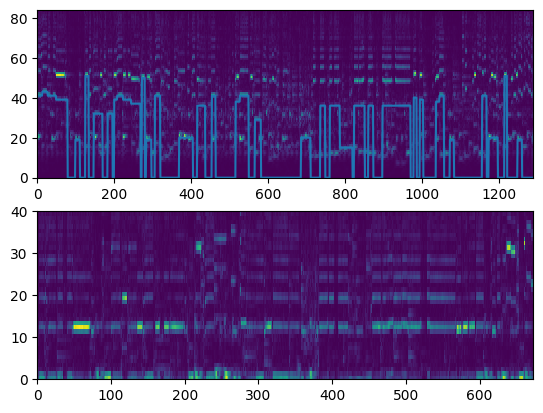

In [62]:
plt.subplot(2, 1, 1)
plt.pcolor(next(iter(E_train.features['cqt']))[0])
plt.plot(next(iter(E_train.features['f0_bins']))[0])
chifted_cqt = shift_cqt_by_f0(next(iter(E_train.features['cqt']))[0],
                              next(iter(E_train.features['f0_bins']))[0],
                              next(iter(E_train.features['voiced']))[0],
                              cqt_frequencies)
plt.subplot(2, 1, 2)
plt.pcolor(chifted_cqt)

In [ ]:
Extractor.register_mapper('overtones', lambda cqt, f0_bins, voiced:
                             shift_cqt_by_f0(cqt, f0_bins, voiced, cqt_frequencies), uniform=False)
Extractor.register_mapper('overtones_freq_mean', lambda overtones:
                             np.mean(overtones, axis=1) if overtones.shape[1] > 0 else np.zeros(overtones.shape[0]))
Extractor.register_mapper('overtones_freq_var', lambda overtones:
                             np.var(overtones, axis=1) if overtones.shape[1] > 0 else np.zeros(overtones.shape[0]))

In [ ]:
E_train.soft_extract()


In [79]:
features = ['rms', 'bpm', 'zero_crossing_rate_mean',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent',
    'overtones_freq_mean', 'overtones_freq_var']

column_names = E_train.get_columns(features)

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features),
    y=y_train.to_numpy(),
)

0:	learn: 0.3098592	total: 45.2ms	remaining: 22.6s
100:	learn: 0.8654147	total: 2.69s	remaining: 10.6s
200:	learn: 0.9405321	total: 5.48s	remaining: 8.16s
300:	learn: 0.9749609	total: 8.28s	remaining: 5.47s
400:	learn: 0.9874804	total: 11s	remaining: 2.73s
499:	learn: 0.9953052	total: 13.8s	remaining: 0us
0:	learn: 0.3223787	total: 44.8ms	remaining: 22.4s
100:	learn: 0.8575900	total: 2.86s	remaining: 11.3s
200:	learn: 0.9420970	total: 5.71s	remaining: 8.49s
300:	learn: 0.9671362	total: 8.42s	remaining: 5.57s
400:	learn: 0.9812207	total: 11.3s	remaining: 2.78s
499:	learn: 0.9859155	total: 14.1s	remaining: 0us
0:	learn: 0.3161189	total: 47.3ms	remaining: 23.6s
100:	learn: 0.8450704	total: 2.91s	remaining: 11.5s
200:	learn: 0.9280125	total: 5.67s	remaining: 8.44s
300:	learn: 0.9687011	total: 8.25s	remaining: 5.45s
400:	learn: 0.9859155	total: 11s	remaining: 2.72s
499:	learn: 0.9921753	total: 13.7s	remaining: 0us
0:	learn: 0.3082942	total: 43.2ms	remaining: 21.6s
100:	learn: 0.8669797	tota

In [80]:
imp = pd.DataFrame(
    data=model.feature_importances_,
    index=E_train.get_columns(features),
    columns=['importance']
)
bad_feats = list(imp[imp['importance'] < 0.1].index)

In [ ]:
bad_feats

In [83]:
features = ['rms', 'bpm', 'zero_crossing_rate_mean',
    'mel48_freq_mean', 'mel48_freq_var',
    'cqt_harmonic_mean', 'cqt_harmonic_freq_mean', 'cqt_harmonic_freq_var',
    'cqt_percussive_mean', 'cqt_percussive_freq_mean', 'cqt_percussive_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'spectral_centroid_mean', 'spectral_centroid_var',
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var',
    'cqt_harmonic_chroma_freq_mean', 'cqt_harmonic_chroma_freq_var',
    'rolloff_mean', 'rolloff_var',
    'bandwidth_mean', 'bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'zero_crossing_rate_mean',
    'voiced_f0_mean', 'voiced_f0_var', 'voiced_percent',
    'overtones_freq_mean', 'overtones_freq_var']

column_names = E_train.get_columns(features)
mask = np.array([x not in bad_feats for x in column_names])

model, acc = train_and_evaluate_catboost(
    X=E_train.numpy(features)[:, mask],
    y=y_train.to_numpy(),
)

0:	learn: 0.2942097	total: 17.7ms	remaining: 8.81s
100:	learn: 0.8513302	total: 990ms	remaining: 3.91s
200:	learn: 0.9311424	total: 1.84s	remaining: 2.74s
300:	learn: 0.9765258	total: 2.66s	remaining: 1.76s
400:	learn: 0.9890454	total: 3.52s	remaining: 870ms
499:	learn: 0.9968701	total: 4.34s	remaining: 0us
0:	learn: 0.3051643	total: 14ms	remaining: 6.98s
100:	learn: 0.8654147	total: 855ms	remaining: 3.38s
200:	learn: 0.9280125	total: 1.7s	remaining: 2.53s
300:	learn: 0.9687011	total: 2.52s	remaining: 1.67s
400:	learn: 0.9827856	total: 3.33s	remaining: 823ms
499:	learn: 0.9890454	total: 4.14s	remaining: 0us
0:	learn: 0.3035994	total: 13.9ms	remaining: 6.95s
100:	learn: 0.8607199	total: 846ms	remaining: 3.34s
200:	learn: 0.9420970	total: 1.66s	remaining: 2.47s
300:	learn: 0.9671362	total: 2.47s	remaining: 1.63s
400:	learn: 0.9906103	total: 3.31s	remaining: 818ms
499:	learn: 0.9921753	total: 4.12s	remaining: 0us
0:	learn: 0.2989045	total: 13.7ms	remaining: 6.84s
100:	learn: 0.8575900	tot

ChatGPT query

Write a python function with a following signature

```
rnd = np.random.default_rng(42)
def crop_by_beats(beat, harmony_specs, percussion_specs, frames_per_beat = 4, number_of_beats=16, number_of_samples=8)
    pass
```

beats is the integer array of frames at which there was a beat
upsample beats , for two neighboring values insert frames_per_beat-1 values between them uniformly cropped to the nearest frame

Next number_of_samples times sample starting position in the upsampled beats array and take number_of_beats * frames_per_beat consequent beats. Position must be sampled aligned to number_of_beats * frames_per_beat.

harmony_specs is a list of several spectrograms with harmonic parts of melody.
for each of harmony spec calculate the mean along time axis (axis = 1) between the consequent beats of the sample including the frames at which there was a beat

percussion_specs is a list of several spectrograms with percussion parts of melody. For each of percussion spec calculate the downsampled spectrogram as with harmony specs but shift the spectrogram so that the first sample was centered at the beat. The resulting length must be the same

return list of tuples containing downsampled spectrograms

In [ ]:
rnd = np.random.default_rng(42)

def crop_by_beats(
    beat,
    harmony_specs,
    percussion_specs,
    frames_per_beat=4,
    number_of_beats=8,
    number_of_samples=8
):
    """
    Upsample the array of integer beat positions and then randomly extract
    (number_of_samples) chunks of length (number_of_beats * frames_per_beat).

    For each chunk, compute the downsampled spectrogram:
      - For harmonic specs: take the mean along the time axis (axis=1)
        between consecutive upsampled-beat boundaries.
      - For percussion specs: take the mean along the time axis over intervals
        shifted so that each is centered at the corresponding upsampled beat.

    Parameters
    ----------
    beat : 1D array-like of int
        Array of frame indices at which a beat occurs. Must be strictly increasing.
    harmony_specs : list of np.ndarray
        Each element is a spectrogram for a harmonic component with shape
        (freq_bins, time_frames).
    percussion_specs : list of np.ndarray
        Each element is a spectrogram for a percussion component with shape
        (freq_bins, time_frames).
    frames_per_beat : int
        Number of subdivisions per original beat when upsampling.
    number_of_beats : int
        How many beats (in terms of upsampled subdivisions) to include in each chunk.
    number_of_samples : int
        How many random chunks to extract.

    Returns
    -------
    list of tuples
        A list (of length `number_of_samples`). Each element is:

            (harmony_downsampled_list, percussion_downsampled_list)

        where `harmony_downsampled_list` and `percussion_downsampled_list` are each
        lists of spectrograms (in the same order as `harmony_specs` and
        `percussion_specs`). Each downsampled spectrogram has shape:

            (freq_bins, number_of_beats * frames_per_beat)
    """

    # 1) Upsample 'beat' by inserting (frames_per_beat - 1) points
    #    uniformly between each pair of consecutive beats.
    up_beats = []
    beat = np.array(beat, dtype=int)
    for i in range(len(beat) - 1):
        start = beat[i]
        end = beat[i + 1]
        diff = end - start

        # Insert frames_per_beat subdivisions between start and end,
        # snapping to the nearest integer frame.
        for k in range(frames_per_beat):
            val = start + round(k * diff / frames_per_beat)
            # Avoid duplicates if rounding yields same as last appended
            if not up_beats or val != up_beats[-1]:
                up_beats.append(val)

    up_beats = np.array(up_beats, dtype=int)

    # 2) We need (number_of_beats * frames_per_beat + 1) upsampled-beat
    #    positions for each chunk (the +1 is because we need the right boundary).
    needed_length = number_of_beats * frames_per_beat + 1
    total_upsampled = len(up_beats)

    # If we cannot extract even one chunk, return empty
    max_start = total_upsampled - needed_length
    if max_start < 0:
        return []

    # Possible start indices must be multiples of (4 * frames_per_beat)
    # so that each chunk is "aligned".
    stride = number_of_beats * frames_per_beat
    possible_starts = np.arange(0, max_start + 1, stride)

    # Randomly choose 'number_of_samples' start indices from these possibilities
    chosen_starts = rnd.choice(possible_starts, size=number_of_samples, replace=True)

    results = []
    for start_idx in chosen_starts:
        # Boundaries for this sample
        boundary_points = up_beats[start_idx : start_idx + needed_length]
        # === 3) Downsample each harmony spec ===
        harmony_downsampled = []
        for spec in harmony_specs:
            # spec has shape (freq_bins, time_frames)
            freq_bins = spec.shape[0]

            # We'll get (number_of_beats * frames_per_beat) intervals
            ds_harm = np.zeros((freq_bins, number_of_beats * frames_per_beat),
                               dtype=spec.dtype)
            for j in range(number_of_beats * frames_per_beat):
                left = boundary_points[j]
                right = boundary_points[j + 1]
                # Take the average along axis=1 (time axis)
                ds_harm[:, j] = spec[:, left:right].mean(axis=1)

            harmony_downsampled.append(ds_harm)

        # === 4) Downsample each percussion spec with centering ===
        percussion_downsampled = []
        percussion_sampled = []
        for spec in percussion_specs:

            freq_bins = spec.shape[0]
            ds_perc = np.zeros((freq_bins, number_of_beats * frames_per_beat),
                               dtype=spec.dtype)

            old_right = None
            for j in range(number_of_beats * frames_per_beat):
                dist = boundary_points[j + 1] - boundary_points[j]
                right = boundary_points[j + 1] - dist // 2
                if old_right is None:
                    left = boundary_points[j] - dist // 2
                    if left < 0:
                        left = 0
                else:
                    left = old_right
                old_right = right

                # Average over the time axis in [left, right)
                chunk = spec[:, left:right]
                ds_perc[:, j] = chunk.mean(axis=1)

            percussion_downsampled.append(ds_perc)

        # One result entry = (list_of_downsampled_harmony_specs, list_of_downsampled_percussion_specs)
        results.append((harmony_downsampled, percussion_downsampled))
    return results

In [ ]:
Extractor.register_extractor('sample',
                             lambda beat, cqt, harmonic, mfcc, cqt_chroma, harmonic_chroma, percussive:
                             crop_by_beats(
                                 beat=beat,
                                 harmony_specs=[cqt, harmonic, mfcc, cqt_chroma, harmonic_chroma],
                                 percussion_specs=[percussive]
                             ), shuffle=True, map_labels=[
                                 ('idx', 's_idx'),
                                 ('y', 's_y'),
                             ])
Extractor.register_extractor('s_cqt', lambda sample: sample[0][0])
Extractor.register_extractor('s_harmonic', lambda sample: sample[0][1])
Extractor.register_extractor('s_mfcc', lambda sample: sample[0][2])
Extractor.register_extractor('s_cqt_chroma', lambda sample: sample[0][3])
Extractor.register_extractor('s_harmonic_chroma', lambda sample: sample[0][4])
Extractor.register_extractor('s_percussive', lambda sample: sample[1][0])

In [ ]:
del E_train.features['sample']
del E_eval.features['sample']
for f in list(E_train.features.keys()):
    if f.startswith('s_'):
        del E_train.features[f]
        del E_eval.features[f]

In [ ]:
E_train.soft_extract()
E_eval.soft_extract()

In [ ]:
Extractor.register_extractor('s_percussive_beat_frames',
                             lambda s_percussive: s_percussive.mean(axis=0))

In [ ]:
E_train.soft_extract()
E_eval.soft_extract()

In [ ]:
plt.subplot(2, 2, 1)
plt.plot(E_train.features['s_percussive_beat_frames'][0])
plt.subplot(2, 2, 2)
plt.plot(E_train.features['s_percussive_beat_frames'][1])
plt.subplot(2, 2, 3)
plt.plot(E_train.features['s_percussive_beat_frames'][2])
plt.subplot(2, 2, 4)
plt.plot(E_train.features['s_percussive_beat_frames'][3])

In [ ]:
from sklearn.cluster import KMeans

class KMeansAdapter(KMeans):
    def transform(self, *args, **kwargs):
        return self.predict(*args, **kwargs).reshape(-1, 1)
    def fit_transform(self, *args, **kwargs):
        return self.fit_predict(*args, **kwargs).reshape(-1, 1)
n_clusters=8
Extractor.register_sklearn_extractor('s_percussive_beat_frames_kmeans', ['s_percussive_beat_frames'], KMeansAdapter(n_clusters=n_clusters))

In [ ]:
E_train.train

In [ ]:
del E_train.features['s_percussive_beat_frames_kmeans']
del E_eval.features['s_percussive_beat_frames_kmeans']
E_train.soft_extract()
E_eval.soft_extract()

In [ ]:
import matplotlib.ticker as ticker
centers = Extractor._stateful_extractors['s_percussive_beat_frames_kmeans'][0].cluster_centers_
h = (len(centers) + 2) // 2
for i, c in enumerate(centers):
    ax = plt.subplot(h, 2, i + 1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=4))
    plt.plot(c)
    plt.grid(axis='x', which='both')

In [ ]:
Extractor.register_sklearn_extractor('s_percussive_beat_frames_svd', ['s_percussive_beat_frames'],
                                     TruncatedSVD(
                                         n_components=n_tsvd_components,
                                         n_iter=n_svd_iter,
                                         random_state=42
                                     ))

In [ ]:
E_train.soft_extract()
E_eval.soft_extract()

In [ ]:
def sum_beats(E, feature_names, idx, to_idx):
    return [np.array(list(x[1])) for x in pd.DataFrame(data=E.get_features(
        [idx] + feature_names
    ), columns=["idx"] + list(E.get_feature_names_vector(feature_names))) \
    .groupby("idx").agg("sum") \
    .loc[E.get_features([to_idx])[:,0]].iterrows()]
E_train.features['percussive_beat_frames_svd'] = sum_beats(E_train, ["s_percussive_beat_frames_svd"], "s_idx", "idx")
E_eval.features['percussive_beat_frames_svd'] = sum_beats(E_eval, ["s_percussive_beat_frames_svd"], "s_idx", "idx")

In [ ]:
plt.plot(E_train.features['percussive_beat_frames_svd'][10])

In [ ]:
def ohe(s):
    v = [0] * n_clusters
    for i in s:
        v[i] += 1
    return v

def aggregate(E, feature_names, idx, to_idx):
    return [np.array(x) for x in pd.DataFrame(data=E.get_features(
        [idx] + feature_names
    ), columns=["idx"] + feature_names) \
    .groupby("idx").agg(ohe) \
    .loc[E.get_features([to_idx])[:,0]]['s_percussive_beat_frames_kmeans']]
E_train.features['percussive_beat_frames_kmeans'] = aggregate(E_train, ["s_percussive_beat_frames_kmeans"], "s_idx", "idx")
E_eval.features['percussive_beat_frames_kmeans'] = aggregate(E_eval, ["s_percussive_beat_frames_kmeans"], "s_idx", "idx")

In [ ]:
import importlib
train_and_evaluate_catboost = importlib.reload(importlib.import_module('model')).train_and_evaluate_catboost

In [ ]:
# ChatGPT query:
#
# I have an array with feature names and I want to generate weights for the features. Some of the feature names look like <name>_<index>.
# I want to make a function receiving a dict with prefixes and corresponding feature weights.
# It should return the np.array of the same shape as feature_names, containing weights.
# If the feature name starts with prefix from the dict then the weight has to be taken from the dict, otherwise it has to be 1.
# Here is the signature:
#
# def assign_feature_weights(feature_names: np.ndarray, weights: dict[str, int]) -> np.ndarray:
#     pass

import numpy as np

def assign_feature_weights(feature_names: np.ndarray, weights: dict[str, float]) -> np.ndarray:
    """
    Assign weights to features based on given prefixes.

    Parameters
    ----------
    feature_names : np.ndarray
        Array of feature names.
    weights : dict[str, float]
        Dictionary mapping a prefix (string) to a weight (float).

    Returns
    -------
    np.ndarray
        An array of the same shape as `feature_names` containing the assigned weights.
        If a feature name starts with any prefix in `weights`, the corresponding weight
        is used. Otherwise, the weight is 1.0.
    """
    result_weights = np.ones_like(feature_names, dtype=float)  # default is 1.0

    for i, fname in enumerate(feature_names):
        for prefix, w in weights.items():
            if fname.startswith(prefix):
                result_weights[i] = w
                break  # Stop at the first matching prefix

    return result_weights

In [ ]:
features = ['stats', 'rms', 'bpm',
    'cqt_per_freq_mean_svd', 'cqt_per_freq_var_svd',
    'harmonic_per_freq_mean_svd', 'harmonic_per_freq_var_svd',
    'percussive_per_freq_mean_svd', 'percussive_per_freq_var_svd',
    'mfcc_quef_mean', 'mfcc_quef_var',
    'cqt_spectral_centroid_mean', 'cqt_spectral_centroid_var',
    'cqt_chroma_mean', 'cqt_chroma_var',
    'harmonic_chroma_freq_mean', 'harmonic_chroma_freq_var',
    'cqt_rolloff_mean', 'cqt_rolloff_var',
    'cqt_bandwidth_mean', 'cqt_bandwidth_var',
    'percept_freq_mean_svd', 'percept_freq_var_svd',
    'voiced_f0_mean', 'f0_var',
    'overtones_freq_mean_svd', 'overtones_freq_var_svd',
    ]

weights = assign_feature_weights(E_eval.get_feature_names_vector(features),
                                 dict(percussive_beat_frames_kmeans=1))
model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['y'])[:,0],
    y_eval=E_eval.get_features(['y'])[:,0],
)

In [ ]:
imp = pd.DataFrame(
    data=model.feature_importances_,
    index=E_train.get_feature_names_vector(features),
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)
imp['stat_name'] = pd.Series(imp.index, index=imp.index).apply(lambda x: int(x[6:]) if x.startswith('stats_') else None)
imp['stat_name'] = imp['stat_name'].apply(lambda x: X_train.columns[int(x) + 2] if not np.isnan(x) else None)
imp